Number of training nodes: 1208
Number of validation nodes: 500
Number of test nodes: 1000
Epoch: 010, Loss: 1.7932, Train Acc: 0.4462, Val Acc: 0.4560, Test Acc: 0.4490
Epoch: 020, Loss: 1.6186, Train Acc: 0.4636, Val Acc: 0.4660, Test Acc: 0.4670
Epoch: 030, Loss: 1.4303, Train Acc: 0.5753, Val Acc: 0.5600, Test Acc: 0.5500
Epoch: 040, Loss: 1.2271, Train Acc: 0.7161, Val Acc: 0.6840, Test Acc: 0.6820
Epoch: 050, Loss: 1.0092, Train Acc: 0.8320, Val Acc: 0.8020, Test Acc: 0.7950


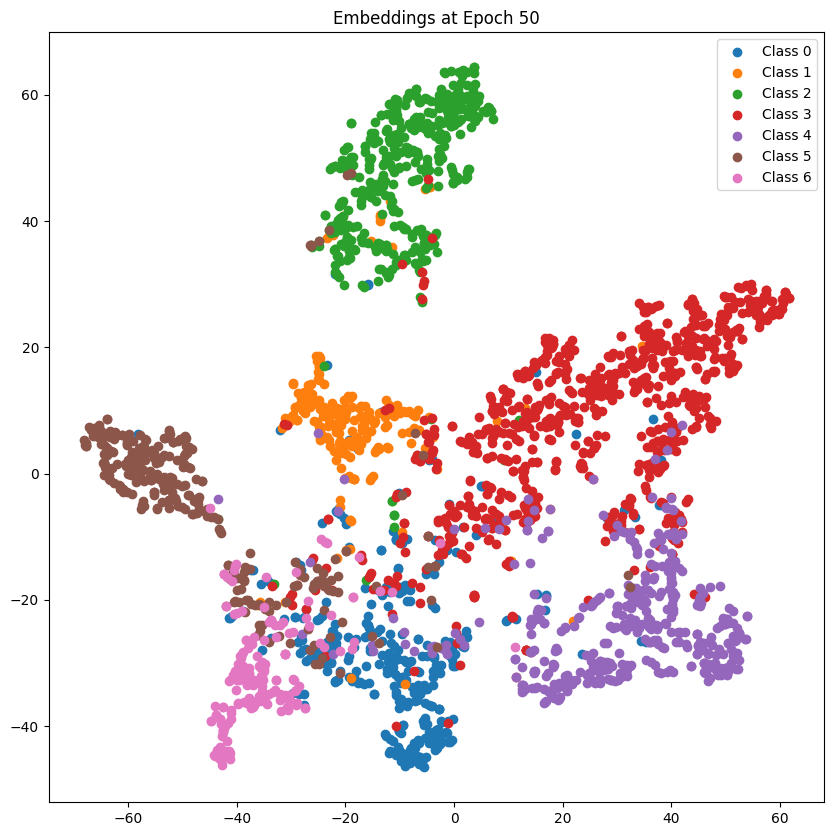

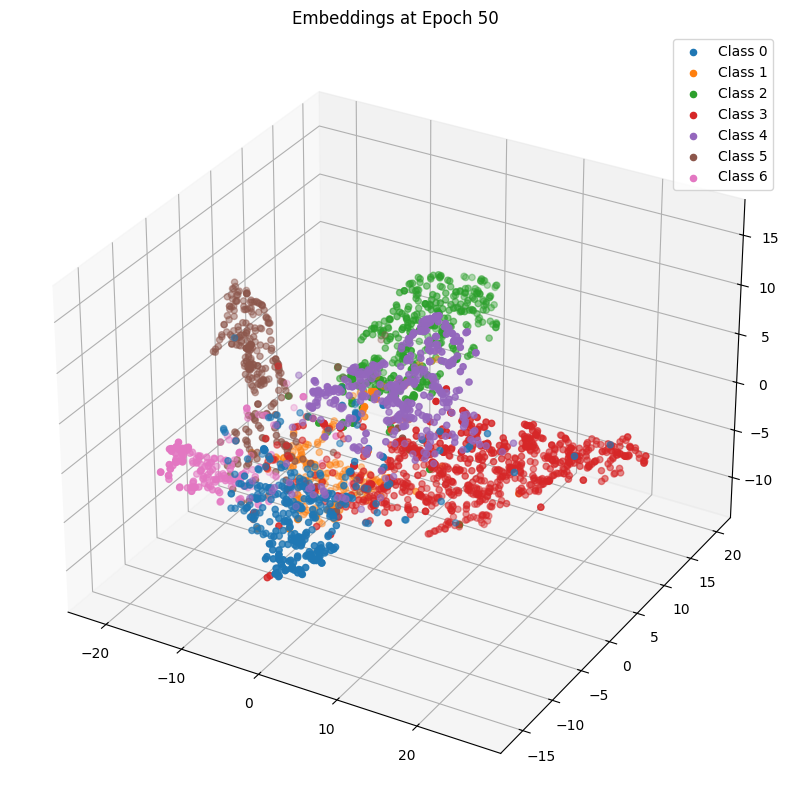

Epoch: 060, Loss: 0.7954, Train Acc: 0.8675, Val Acc: 0.8340, Test Acc: 0.8310
Epoch: 070, Loss: 0.6469, Train Acc: 0.8916, Val Acc: 0.8560, Test Acc: 0.8510
Epoch: 080, Loss: 0.5312, Train Acc: 0.9031, Val Acc: 0.8580, Test Acc: 0.8620
Epoch: 090, Loss: 0.4480, Train Acc: 0.9106, Val Acc: 0.8700, Test Acc: 0.8700
Epoch: 100, Loss: 0.3735, Train Acc: 0.9222, Val Acc: 0.8800, Test Acc: 0.8690


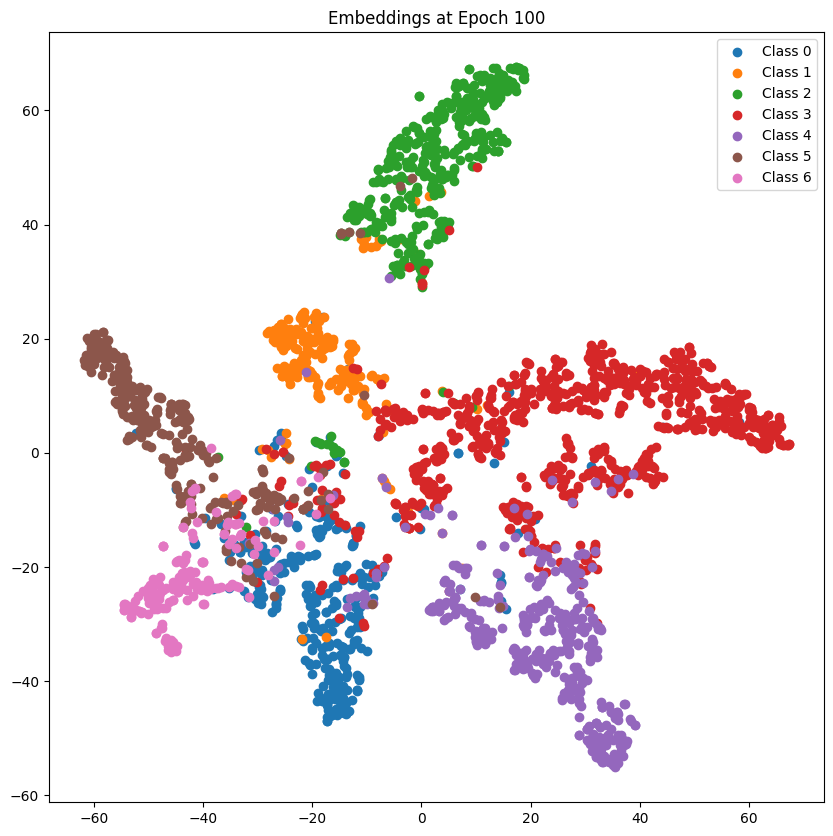

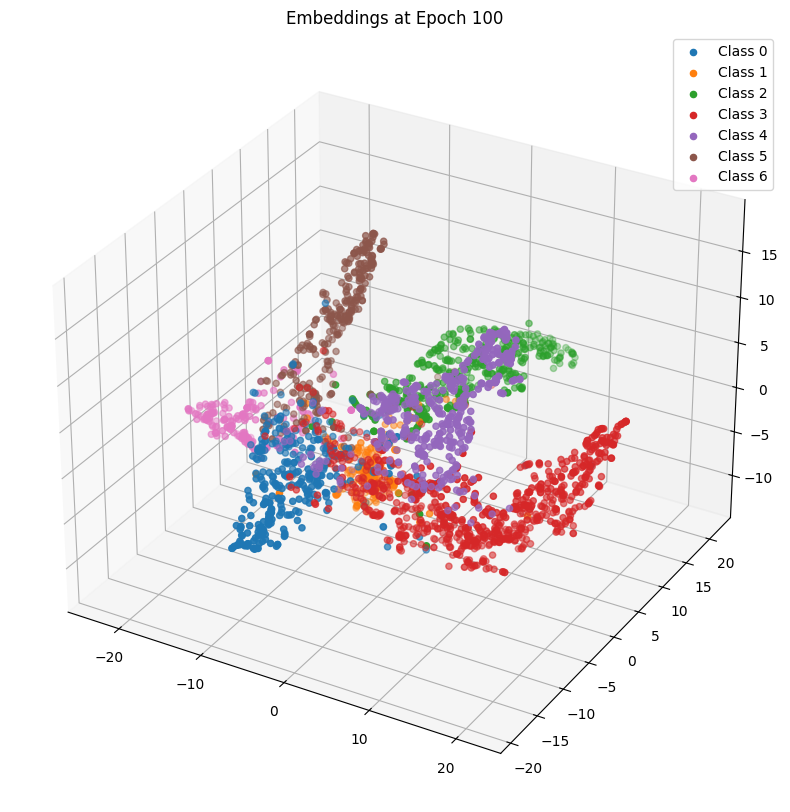

Epoch: 110, Loss: 0.3348, Train Acc: 0.9288, Val Acc: 0.8860, Test Acc: 0.8730
Epoch: 120, Loss: 0.3001, Train Acc: 0.9338, Val Acc: 0.8820, Test Acc: 0.8750
Epoch: 130, Loss: 0.2872, Train Acc: 0.9412, Val Acc: 0.8840, Test Acc: 0.8750
Epoch: 140, Loss: 0.2615, Train Acc: 0.9445, Val Acc: 0.8840, Test Acc: 0.8770
Epoch: 150, Loss: 0.2318, Train Acc: 0.9495, Val Acc: 0.8840, Test Acc: 0.8760


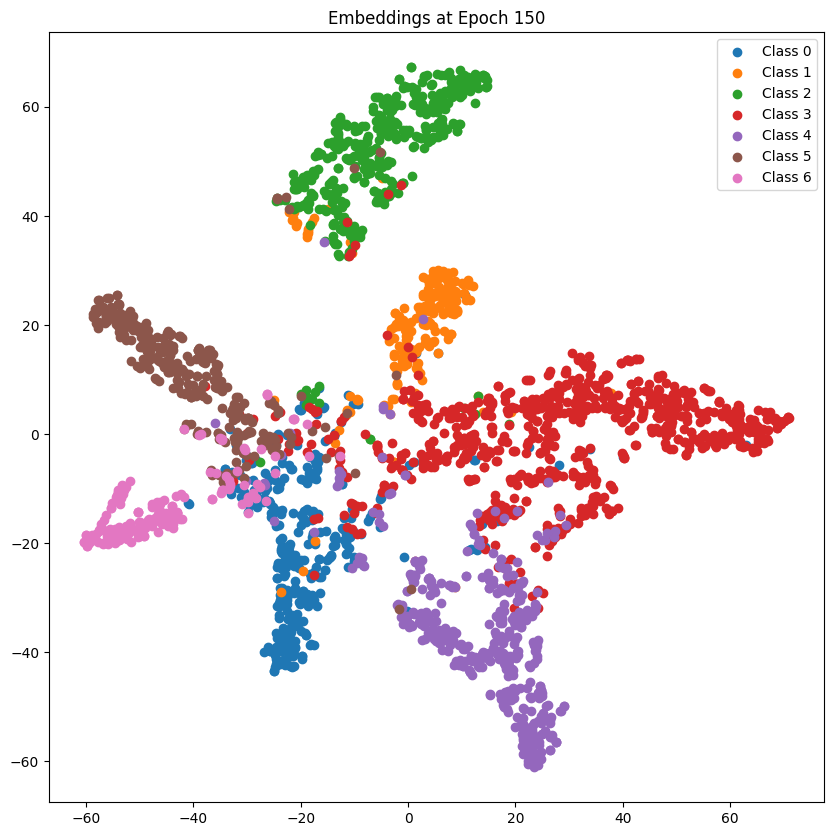

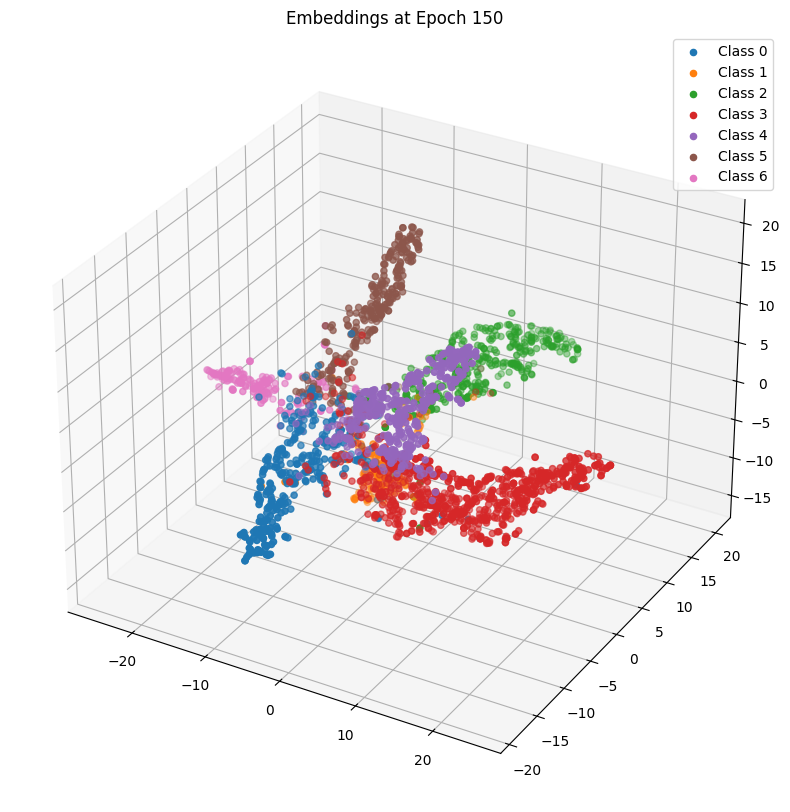

Epoch: 160, Loss: 0.2315, Train Acc: 0.9512, Val Acc: 0.8880, Test Acc: 0.8710
Epoch: 170, Loss: 0.2091, Train Acc: 0.9528, Val Acc: 0.8860, Test Acc: 0.8750
Epoch: 180, Loss: 0.2024, Train Acc: 0.9561, Val Acc: 0.8900, Test Acc: 0.8750
Epoch: 190, Loss: 0.2083, Train Acc: 0.9578, Val Acc: 0.8900, Test Acc: 0.8710
Epoch: 200, Loss: 0.1761, Train Acc: 0.9603, Val Acc: 0.8880, Test Acc: 0.8720


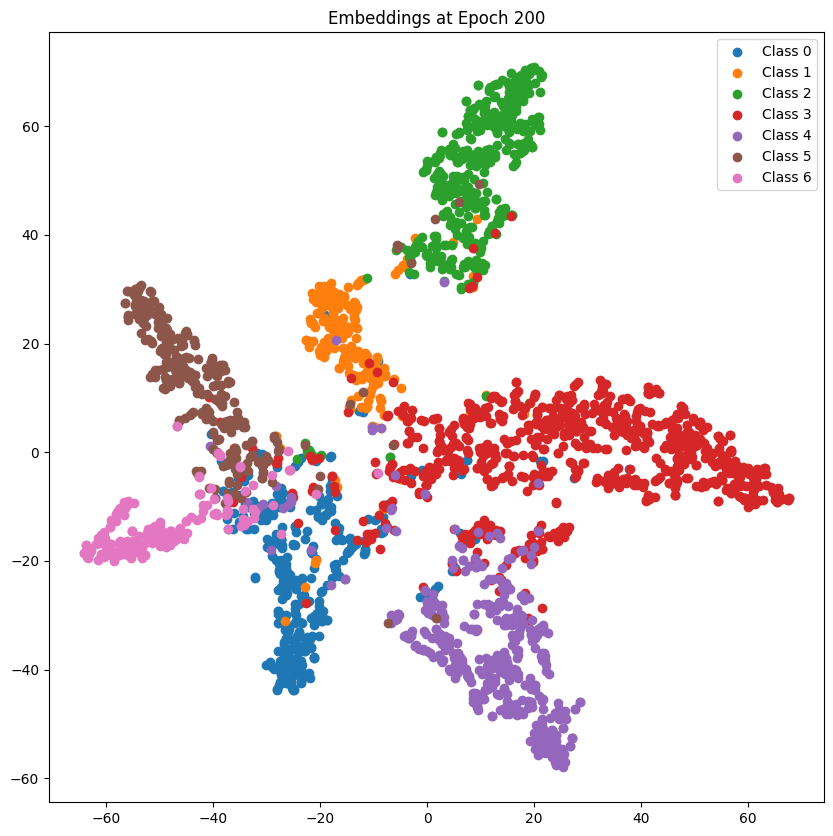

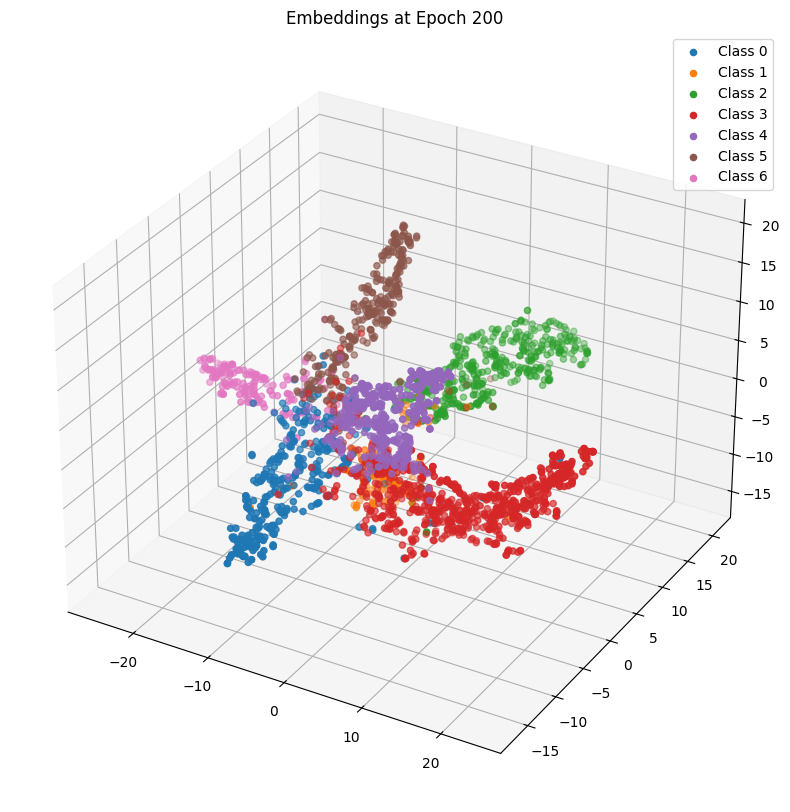

In [8]:
import torch
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from sklearn.manifold import TSNE

import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', split='full', num_test=200, num_val=100)

# print number of nodes in training, validation, and test set
print(f'Number of training nodes: {dataset[0].train_mask.sum()}')
print(f'Number of validation nodes: {dataset[0].val_mask.sum()}')
print(f'Number of test nodes: {dataset[0].test_mask.sum()}')

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.linear = torch.nn.Linear(hidden_channels * heads, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = self.linear(x)
        return F.log_softmax(x, dim=1)

def train(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    logits, accs = model(data), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

def plot_embeddings(model, data, epoch):
    model.eval()
    with torch.no_grad():
        out = model(data)
    z = TSNE(n_components=2).fit_transform(out.cpu().numpy())
    y = data.y.cpu().numpy()

    plt.figure(figsize=(10, 10))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], label=f'Class {i}')
    plt.legend()
    plt.title(f'Embeddings at Epoch {epoch}')
    plt.show()
    
def plot_embeddings_3d(model, data, epoch):
    model.eval()
    with torch.no_grad():
        out = model(data)
    z = TSNE(n_components=3).fit_transform(out.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for i in range(dataset.num_classes):
        ax.scatter(z[y == i, 0], z[y == i, 1], z[y == i, 2], label=f'Class {i}')
    plt.legend()
    plt.title(f'Embeddings at Epoch {epoch}')
    plt.show()

# Initialize model, optimizer, and data
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GAT(dataset.num_node_features, 128, 8).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# Training loop
for epoch in range(1, 201):
    loss = train(model, data, optimizer)
    if epoch % 10 == 0:
        train_acc, val_acc, test_acc = test(model, data)
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')
        if epoch % 50 == 0:
            plot_embeddings(model, data, epoch)
            plot_embeddings_3d(model, data, epoch)